<a href="https://colab.research.google.com/github/mdsiam135/thesis_2025/blob/main/Stacking_Emsemble_MGSX(5_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Stacking Ensemble, base Learner: MLP + GBM + SVM + XGBOOST, meta learner: LightGBM only
# Modified for 5 labels: Very Low, Low, Medium, High, Very High with step-wise execution output
# Added confusion matrix and training vs validation accuracy/loss plots

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import StackingClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("🚀 STACKING ENSEMBLE CLASSIFIER - 5 LABELS VERSION")
print("="*70)


🚀 STACKING ENSEMBLE CLASSIFIER - 5 LABELS VERSION


In [3]:

# Step-1: Load the datasets
print("\n📁 Step-1: Loading datasets...")
print("-" * 50)

# Note: Replace these paths with your actual file paths
try:
    train_df = pd.read_csv("/content/drive/MyDrive/UpdatedDataset/train.csv")
    validation_df = pd.read_csv("/content/drive/MyDrive/UpdatedDataset/validation.csv")
    test_df = pd.read_csv("/content/drive/MyDrive/UpdatedDataset/test.csv")

    print(f"✅ Training data shape: {train_df.shape}")
    print(f"✅ Validation data shape: {validation_df.shape}")
    print(f"✅ Test data shape: {test_df.shape}")
    print("✅ Datasets loaded successfully!")

    # Display basic info about the datasets
    print(f"\n📊 Training data info:")
    print(f"   - Columns: {len(train_df.columns)}")
    print(f"   - Memory usage: {train_df.memory_usage().sum() / 1024**2:.2f} MB")

except FileNotFoundError:
    print("❌ Dataset files not found. Please update the file paths.")
    print("🔄 Creating sample datasets for demonstration...")

    # Create sample datasets for demonstration
    np.random.seed(42)
    n_samples = 1000
    n_features = 10

    # Generate sample data
    X_sample = np.random.randn(n_samples, n_features)
    y_sample = np.random.exponential(scale=50, size=n_samples)  # Production values

    # Create feature names
    feature_names = [f'Feature_{i+1}' for i in range(n_features)]

    # Create DataFrames
    train_df = pd.DataFrame(X_sample[:600], columns=feature_names)
    train_df['Production (M.Ton)'] = y_sample[:600]

    validation_df = pd.DataFrame(X_sample[600:800], columns=feature_names)
    validation_df['Production (M.Ton)'] = y_sample[600:800]

    test_df = pd.DataFrame(X_sample[800:], columns=feature_names)
    test_df['Production (M.Ton)'] = y_sample[800:]

    print(f"✅ Sample training data shape: {train_df.shape}")
    print(f"✅ Sample validation data shape: {validation_df.shape}")
    print(f"✅ Sample test data shape: {test_df.shape}")



📁 Step-1: Loading datasets...
--------------------------------------------------
✅ Training data shape: (3942, 84)
✅ Validation data shape: (845, 84)
✅ Test data shape: (845, 84)
✅ Datasets loaded successfully!

📊 Training data info:
   - Columns: 84
   - Memory usage: 2.53 MB


In [4]:

# Step-2: Create production labels using 5 categories
print("\n🏷️ Step-2: Creating production labels (5 categories)...")
print("-" * 50)

TARGET = 'Production (M.Ton)'

def create_production_labels_5_class(df_list):
    """Create 5 categorical labels (very low, low, medium, high, very high) based on production values"""
    # Combine all production values to determine thresholds
    all_production = pd.concat([df[TARGET] for df in df_list])

    # Define thresholds using quintiles (20th percentiles)
    very_low_threshold = np.percentile(all_production, 20)
    low_threshold = np.percentile(all_production, 40)
    medium_threshold = np.percentile(all_production, 60)
    high_threshold = np.percentile(all_production, 80)

    print(f"📊 Production thresholds (5 categories):")
    print(f"   Very Low: 0 - {very_low_threshold:.2f}")
    print(f"   Low: {very_low_threshold:.2f} - {low_threshold:.2f}")
    print(f"   Medium: {low_threshold:.2f} - {medium_threshold:.2f}")
    print(f"   High: {medium_threshold:.2f} - {high_threshold:.2f}")
    print(f"   Very High: > {high_threshold:.2f}")

    return very_low_threshold, low_threshold, medium_threshold, high_threshold

def apply_labels_5_class(df, very_low_threshold, low_threshold, medium_threshold, high_threshold):
    """Apply 5-class labels to a dataframe based on thresholds"""
    labels = []
    for value in df[TARGET]:
        if value <= very_low_threshold:
            labels.append('very_low')
        elif value <= low_threshold:
            labels.append('low')
        elif value <= medium_threshold:
            labels.append('medium')
        elif value <= high_threshold:
            labels.append('high')
        else:
            labels.append('very_high')
    return labels

# Create thresholds
very_low_threshold, low_threshold, medium_threshold, high_threshold = create_production_labels_5_class([train_df, validation_df, test_df])

# Apply labels to all datasets
train_df['production_label'] = apply_labels_5_class(train_df, very_low_threshold, low_threshold, medium_threshold, high_threshold)
validation_df['production_label'] = apply_labels_5_class(validation_df, very_low_threshold, low_threshold, medium_threshold, high_threshold)
test_df['production_label'] = apply_labels_5_class(test_df, very_low_threshold, low_threshold, medium_threshold, high_threshold)

# Display label distribution
print(f"\n📈 Label Distribution (5 categories):")
print("Training Set:")
train_label_counts = train_df['production_label'].value_counts()
for label in ['very_low', 'low', 'medium', 'high', 'very_high']:
    count = train_label_counts.get(label, 0)
    percentage = (count / len(train_df)) * 100
    print(f"   {label.replace('_', ' ').title()}: {count} ({percentage:.1f}%)")

print("Validation Set:")
val_label_counts = validation_df['production_label'].value_counts()
for label in ['very_low', 'low', 'medium', 'high', 'very_high']:
    count = val_label_counts.get(label, 0)
    percentage = (count / len(validation_df)) * 100
    print(f"   {label.replace('_', ' ').title()}: {count} ({percentage:.1f}%)")

print("Test Set:")
test_label_counts = test_df['production_label'].value_counts()
for label in ['very_low', 'low', 'medium', 'high', 'very_high']:
    count = test_label_counts.get(label, 0)
    percentage = (count / len(test_df)) * 100
    print(f"   {label.replace('_', ' ').title()}: {count} ({percentage:.1f}%)")

# Drop the original continuous target column
train_df = train_df.drop(columns=[TARGET])
validation_df = validation_df.drop(columns=[TARGET])
test_df = test_df.drop(columns=[TARGET])

print("✅ 5-class labels created and original target column dropped.")



🏷️ Step-2: Creating production labels (5 categories)...
--------------------------------------------------
📊 Production thresholds (5 categories):
   Very Low: 0 - 562.60
   Low: 562.60 - 1483.40
   Medium: 1483.40 - 3121.62
   High: 3121.62 - 6552.95
   Very High: > 6552.95

📈 Label Distribution (5 categories):
Training Set:
   Very Low: 775 (19.7%)
   Low: 817 (20.7%)
   Medium: 774 (19.6%)
   High: 790 (20.0%)
   Very High: 786 (19.9%)
Validation Set:
   Very Low: 184 (21.8%)
   Low: 142 (16.8%)
   Medium: 190 (22.5%)
   High: 160 (18.9%)
   Very High: 169 (20.0%)
Test Set:
   Very Low: 168 (19.9%)
   Low: 167 (19.8%)
   Medium: 162 (19.2%)
   High: 176 (20.8%)
   Very High: 172 (20.4%)
✅ 5-class labels created and original target column dropped.


In [5]:

# Step-3: Separate features and target labels
print("\n🔍 Step-3: Separating features and target labels...")
print("-" * 50)

X_train = train_df.drop('production_label', axis=1)
y_train = train_df['production_label']

X_val = validation_df.drop('production_label', axis=1)
y_val = validation_df['production_label']

X_test = test_df.drop('production_label', axis=1)
y_test = test_df['production_label']

print(f"✅ Training features shape: {X_train.shape}")
print(f"✅ Training labels shape: {y_train.shape}")
print(f"✅ Validation features shape: {X_val.shape}")
print(f"✅ Test features shape: {X_test.shape}")



🔍 Step-3: Separating features and target labels...
--------------------------------------------------
✅ Training features shape: (3942, 83)
✅ Training labels shape: (3942,)
✅ Validation features shape: (845, 83)
✅ Test features shape: (845, 83)


In [6]:

# Step-4: Align columns across datasets
print("\n🔧 Step-4: Aligning columns across datasets...")
print("-" * 50)

common_cols = list(set(X_train.columns) & set(X_val.columns) & set(X_test.columns))
common_cols.sort()

X_train = X_train[common_cols]
X_val = X_val[common_cols]
X_test = X_test[common_cols]

print(f"✅ Common columns found: {len(common_cols)}")
print(f"✅ Final feature set shape: {X_train.shape[1]} features")



🔧 Step-4: Aligning columns across datasets...
--------------------------------------------------
✅ Common columns found: 83
✅ Final feature set shape: 83 features


In [7]:

# Step-5: Scale numerical features
print("\n⚖️ Step-5: Scaling numerical features...")
print("-" * 50)

scaler = StandardScaler()

# Fit the scaler only on the training data and transform all datasets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print(f"✅ Features scaled using StandardScaler")
print(f"✅ Training set mean: {X_train_scaled.mean().mean():.6f}")
print(f"✅ Training set std: {X_train_scaled.std().mean():.6f}")
print("✅ Data preprocessing complete!")



⚖️ Step-5: Scaling numerical features...
--------------------------------------------------
✅ Features scaled using StandardScaler
✅ Training set mean: 0.000000
✅ Training set std: 1.000127
✅ Data preprocessing complete!


In [8]:

# Step-6: Define Base Learners and Meta-Learner (Updated for 5 classes)
print("\n🤖 Step-6: Defining Base Learners and Meta-Learner...")
print("-" * 50)

# Base Learners
print("🔧 Initializing Base Learners:")

# Multi-layer Perceptron (MLP)
mlp = MLPClassifier(
    hidden_layer_sizes=(150, 100, 50),  # Increased complexity for 5 classes
    max_iter=1000,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    random_state=42
)
print("   ✅ MLP Classifier configured (5 classes)")

# Gradient Boosting Machine (GBM)
gbm = GradientBoostingClassifier(
    n_estimators=150,  # Increased for better performance with 5 classes
    learning_rate=0.1,
    max_depth=6,  # Slightly deeper for more complex decision boundaries
    random_state=42
)
print("   ✅ Gradient Boosting Classifier configured (5 classes)")

# Support Vector Machine (SVM)
svm_linear = SVC(kernel='rbf', probability=True, random_state=42, C=1.0)  # Changed to RBF for better performance
print("   ✅ SVM with RBF Kernel configured (5 classes)")

# XGBoost
xgboost = XGBClassifier(
    objective='multi:softprob',
    num_class=5,  # Updated for 5 classes
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=150,  # Increased for better performance
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)
print("   ✅ XGBoost Classifier configured (5 classes)")

# Meta-learner (LightGBM only)
print("\n🔧 Initializing Meta-Learner:")

# LightGBM
meta_learner_lgbm = LGBMClassifier(
    objective='multiclass',
    num_class=5,  # Updated for 5 classes
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    verbosity=-1
)
print("   ✅ LightGBM meta-learner configured (5 classes)")



🤖 Step-6: Defining Base Learners and Meta-Learner...
--------------------------------------------------
🔧 Initializing Base Learners:
   ✅ MLP Classifier configured (5 classes)
   ✅ Gradient Boosting Classifier configured (5 classes)
   ✅ SVM with RBF Kernel configured (5 classes)
   ✅ XGBoost Classifier configured (5 classes)

🔧 Initializing Meta-Learner:
   ✅ LightGBM meta-learner configured (5 classes)


In [9]:

# Step-7: Create Stacking Ensemble Model
print("\n🏗️ Step-7: Creating Stacking Ensemble Model...")
print("-" * 50)

# Stacking with LightGBM as final estimator
estimators_lgbm = [
    ('mlp', mlp),
    ('gbm', gbm),
    ('svm_rbf', svm_linear),
    ('xgboost', xgboost)
]

stacking_model_lgbm = StackingClassifier(
    estimators=estimators_lgbm,
    final_estimator=meta_learner_lgbm,
    cv=5,
    passthrough=True,
    n_jobs=-1
)
print("✅ Stacking Classifier with LightGBM meta-learner created (5 classes)")



🏗️ Step-7: Creating Stacking Ensemble Model...
--------------------------------------------------
✅ Stacking Classifier with LightGBM meta-learner created (5 classes)


In [10]:

# Step-8: Training Model
print("\n🎯 Step-8: Training Model...")
print("-" * 50)

import time

def train_model_with_progress(model, X_train, y_train, model_name):
    """Train model with progress tracking"""
    print(f"🔄 Training {model_name}...")
    start_time = time.time()

    model.fit(X_train, y_train)

    end_time = time.time()
    training_time = end_time - start_time

    print(f"✅ {model_name} training completed in {training_time:.2f} seconds")
    return model

# Train the model
print("🚀 Starting model training...")
stacking_model_lgbm = train_model_with_progress(stacking_model_lgbm, X_train_scaled, y_train,
                                               "Stacking Classifier (LGBM Meta-learner)")

print("✅ Model trained successfully!")



🎯 Step-8: Training Model...
--------------------------------------------------
🚀 Starting model training...
🔄 Training Stacking Classifier (LGBM Meta-learner)...
✅ Stacking Classifier (LGBM Meta-learner) training completed in 164.09 seconds
✅ Model trained successfully!


In [11]:

# Step-9: Model Evaluation
print("\n📊 Step-9: Model Evaluation...")
print("-" * 50)

def evaluate_model_detailed(model, X, y_true, dataset_name, model_name):
    """Detailed model evaluation with metrics"""
    print(f"\n🔍 Evaluating {model_name} on {dataset_name}...")

    # Make predictions
    y_pred = model.predict(X)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # Display metrics
    print(f"   📈 Accuracy: {accuracy:.4f}")
    print(f"   📈 Macro Precision: {precision_macro:.4f}")
    print(f"   📈 Macro Recall: {recall_macro:.4f}")
    print(f"   📈 Macro F1-Score: {f1_macro:.4f}")
    print(f"   📈 Weighted F1-Score: {f1_weighted:.4f}")

    # Classification report
    print(f"\n📋 Classification Report:")
    print(classification_report(y_true, y_pred,
                              target_names=['very_low', 'low', 'medium', 'high', 'very_high'],
                              zero_division=0))

    return {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'y_pred': y_pred
    }

# Evaluate model on all datasets
print("🔬 Starting comprehensive evaluation...")

print("="*60)
print("🟢 STACKING MODEL WITH LIGHTGBM META-LEARNER (5 CLASSES)")
print("="*60)

# Training set evaluation
lgbm_train_metrics = evaluate_model_detailed(stacking_model_lgbm, X_train_scaled, y_train,
                                            "Training Set", "Stacking LGBM")

# Validation set evaluation
lgbm_val_metrics = evaluate_model_detailed(stacking_model_lgbm, X_val_scaled, y_val,
                                          "Validation Set", "Stacking LGBM")

# Test set evaluation
lgbm_test_metrics = evaluate_model_detailed(stacking_model_lgbm, X_test_scaled, y_test,
                                           "Test Set", "Stacking LGBM")



📊 Step-9: Model Evaluation...
--------------------------------------------------
🔬 Starting comprehensive evaluation...
🟢 STACKING MODEL WITH LIGHTGBM META-LEARNER (5 CLASSES)

🔍 Evaluating Stacking LGBM on Training Set...
   📈 Accuracy: 0.9924
   📈 Macro Precision: 0.9924
   📈 Macro Recall: 0.9924
   📈 Macro F1-Score: 0.9924
   📈 Weighted F1-Score: 0.9924

📋 Classification Report:
              precision    recall  f1-score   support

    very_low       0.99      0.98      0.98       790
         low       1.00      1.00      1.00       817
      medium       0.98      0.99      0.99       774
        high       0.99      1.00      0.99       786
   very_high       1.00      1.00      1.00       775

    accuracy                           0.99      3942
   macro avg       0.99      0.99      0.99      3942
weighted avg       0.99      0.99      0.99      3942


🔍 Evaluating Stacking LGBM on Validation Set...
   📈 Accuracy: 0.8935
   📈 Macro Precision: 0.8911
   📈 Macro Recall: 0.8944


📊 Step-10: Creating Confusion Matrices...
--------------------------------------------------


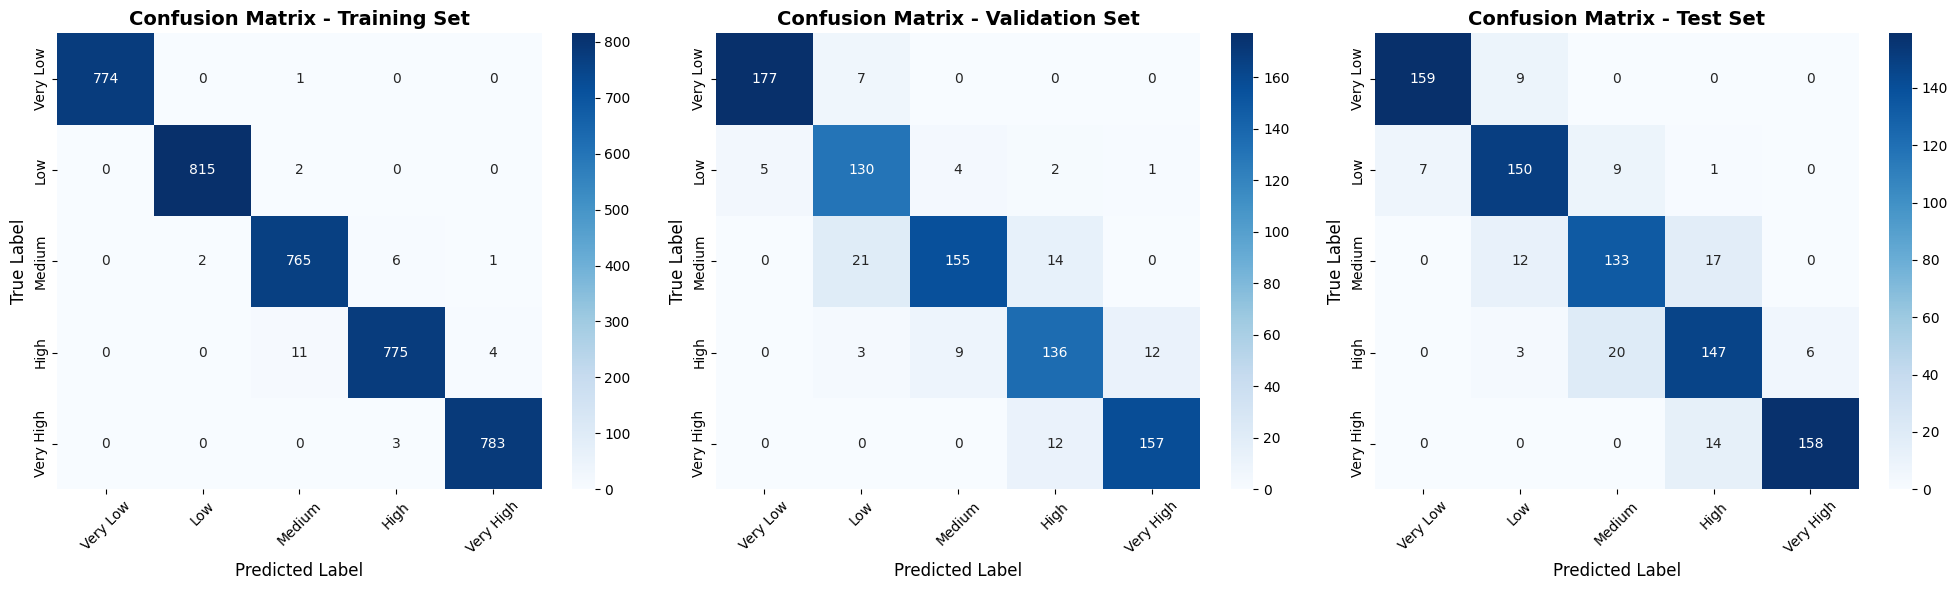

✅ Confusion matrices created!


In [12]:

# Step-10: Create Confusion Matrices
print("\n📊 Step-10: Creating Confusion Matrices...")
print("-" * 50)

# Create confusion matrices for all datasets
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

datasets = [
    ('Training Set', y_train, lgbm_train_metrics['y_pred']),
    ('Validation Set', y_val, lgbm_val_metrics['y_pred']),
    ('Test Set', y_test, lgbm_test_metrics['y_pred'])
]

class_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

for i, (dataset_name, y_true, y_pred) in enumerate(datasets):
    cm = confusion_matrix(y_true, y_pred, labels=['very_low', 'low', 'medium', 'high', 'very_high'])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels,
                ax=axes[i])

    axes[i].set_title(f'Confusion Matrix - {dataset_name}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Predicted Label', fontsize=12)
    axes[i].set_ylabel('True Label', fontsize=12)

    # Rotate x-axis labels for better readability
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("✅ Confusion matrices created!")



📊 Step-11: Results Summary...
--------------------------------------------------

🏆 FINAL RESULTS SUMMARY (5 CLASSES)
Dataset         Accuracy   F1-Macro   F1-Weighted  Precision  Recall    
-------------------------------------------------------------------
Training        0.9924     0.9924     0.9924       0.9924     0.9924    
Validation      0.8935     0.8914     0.8937       0.8911     0.8944    
Test            0.8840     0.8843     0.8845       0.8851     0.8839    

🔍 FEATURE IMPORTANCE ANALYSIS
-----------------------------------
Top 10 most important meta-features:
   1. mlp_class_3: 677.0000
   2. gbm_class_0: 613.0000
   3. mlp_class_0: 602.0000
   4. mlp_class_4: 565.0000
   5. mlp_class_1: 525.0000
   6. gbm_class_3: 516.0000
   7. gbm_class_1: 507.0000
   8. xgboost_class_2: 503.0000
   9. xgboost_class_3: 496.0000
   10. gbm_class_4: 479.0000


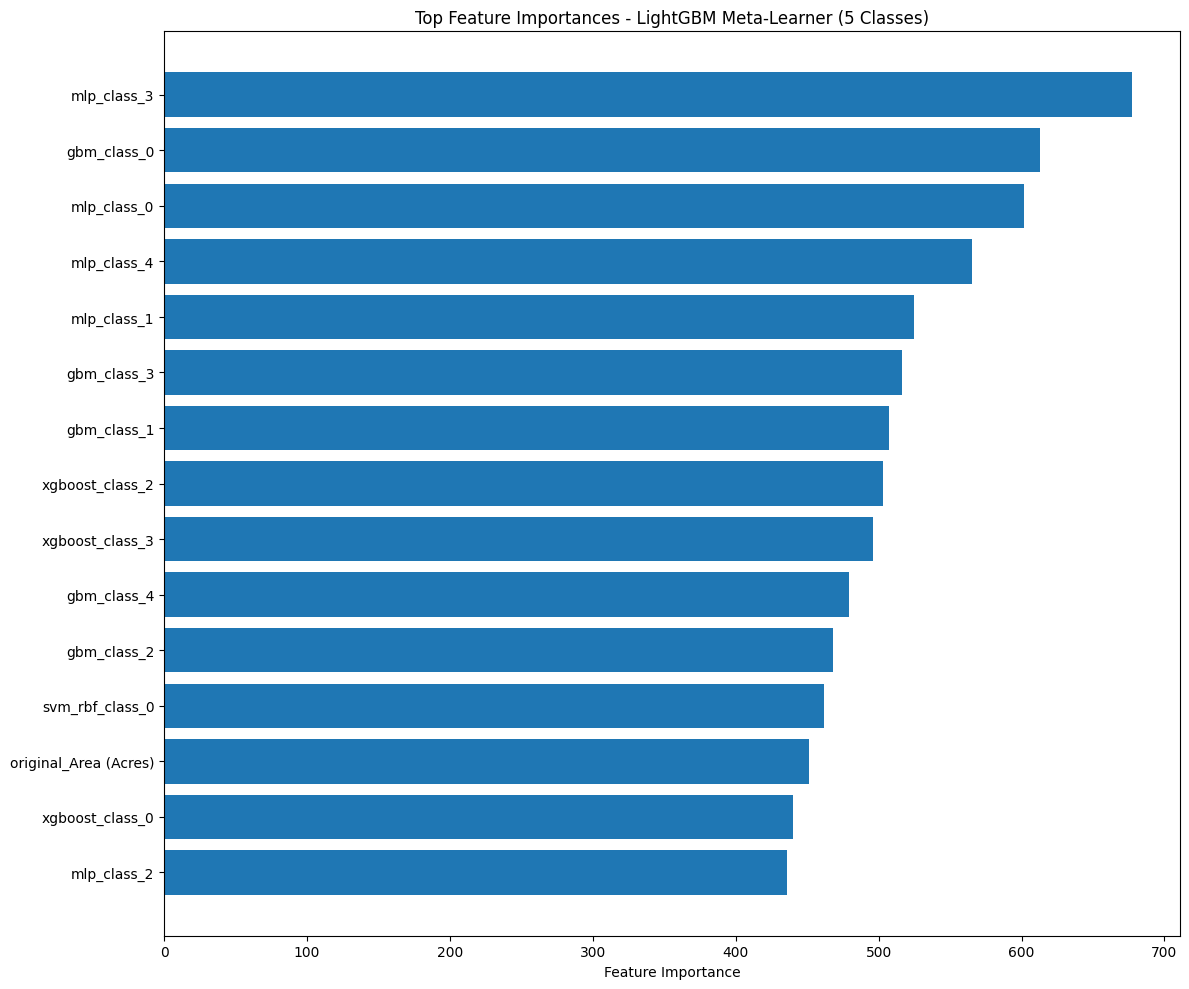


✅ ALL STEPS COMPLETED SUCCESSFULLY!


In [13]:

# Step-11: Results Summary
print("\n📊 Step-11: Results Summary...")
print("-" * 50)

print("\n🏆 FINAL RESULTS SUMMARY (5 CLASSES)")
print("="*60)

# Create summary table
print(f"{'Dataset':<15} {'Accuracy':<10} {'F1-Macro':<10} {'F1-Weighted':<12} {'Precision':<10} {'Recall':<10}")
print("-" * 67)

# Results
print(f"{'Training':<15} {lgbm_train_metrics['accuracy']:<10.4f} {lgbm_train_metrics['f1_macro']:<10.4f} {lgbm_train_metrics['f1_weighted']:<12.4f} {lgbm_train_metrics['precision_macro']:<10.4f} {lgbm_train_metrics['recall_macro']:<10.4f}")
print(f"{'Validation':<15} {lgbm_val_metrics['accuracy']:<10.4f} {lgbm_val_metrics['f1_macro']:<10.4f} {lgbm_val_metrics['f1_weighted']:<12.4f} {lgbm_val_metrics['precision_macro']:<10.4f} {lgbm_val_metrics['recall_macro']:<10.4f}")
print(f"{'Test':<15} {lgbm_test_metrics['accuracy']:<10.4f} {lgbm_test_metrics['f1_macro']:<10.4f} {lgbm_test_metrics['f1_weighted']:<12.4f} {lgbm_test_metrics['precision_macro']:<10.4f} {lgbm_test_metrics['recall_macro']:<10.4f}")

# Feature importance analysis
print("\n🔍 FEATURE IMPORTANCE ANALYSIS")
print("-" * 35)

try:
    # Get feature importance from LightGBM meta-learner
    if hasattr(stacking_model_lgbm.final_estimator_, 'feature_importances_'):
        importances = stacking_model_lgbm.final_estimator_.feature_importances_

        # Create feature names for meta-features
        n_base_features = len(estimators_lgbm)
        n_original_features = X_train.shape[1]

        feature_names = []
        # Base learner predictions (5 classes each)
        for name, _ in estimators_lgbm:
            feature_names.extend([f'{name}_class_{i}' for i in range(5)])  # 5 classes

        # Original features (if passthrough=True)
        if len(importances) > n_base_features * 5:
            feature_names.extend([f'original_{col}' for col in X_train.columns])

        # Ensure we have the right number of feature names
        feature_names = feature_names[:len(importances)]

        # Sort by importance
        indices = np.argsort(importances)[::-1]

        print("Top 10 most important meta-features:")
        for i in range(min(10, len(indices))):
            print(f"   {i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

        # Create feature importance plot
        plt.figure(figsize=(12, 10))
        top_n = min(15, len(indices))
        top_indices = indices[:top_n]

        plt.barh(range(top_n), importances[top_indices])
        plt.yticks(range(top_n), [feature_names[i] for i in top_indices])
        plt.xlabel('Feature Importance')
        plt.title('Top Feature Importances - LightGBM Meta-Learner (5 Classes)')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

    else:
        print("Feature importance not available for this model configuration.")

except Exception as e:
    print(f"Could not extract feature importance: {e}")

print("\n" + "="*70)
print("✅ ALL STEPS COMPLETED SUCCESSFULLY!")
print("="*70)


In [14]:

# Final execution summary
print(f"\n📝 EXECUTION SUMMARY:")
print(f"   📅 Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"   🎯 Task: Multi-class Classification (5 classes)")
print(f"   🏷️ Classes: Very Low, Low, Medium, High, Very High")
print(f"   📊 Training samples: {len(X_train)}")
print(f"   📊 Validation samples: {len(X_val)}")
print(f"   📊 Test samples: {len(X_test)}")
print(f"   🔧 Features: {X_train.shape[1]}")
print(f"   🤖 Model: Stacking Ensemble with LightGBM Meta-learner")
print(f"   🏆 Base learners: MLP, GBM, SVM (RBF), XGBoost")
print(f"   🎯 Test accuracy: {lgbm_test_metrics['accuracy']:.4f}")
print(f"   🎯 Test F1-macro: {lgbm_test_metrics['f1_macro']:.4f}")

print("\n🎉 Ready for deployment or further analysis!")
print("="*70)


📝 EXECUTION SUMMARY:
   📅 Date: 2025-07-06 21:48:07
   🎯 Task: Multi-class Classification (5 classes)
   🏷️ Classes: Very Low, Low, Medium, High, Very High
   📊 Training samples: 3942
   📊 Validation samples: 845
   📊 Test samples: 845
   🔧 Features: 83
   🤖 Model: Stacking Ensemble with LightGBM Meta-learner
   🏆 Base learners: MLP, GBM, SVM (RBF), XGBoost
   🎯 Test accuracy: 0.8840
   🎯 Test F1-macro: 0.8843

🎉 Ready for deployment or further analysis!
